In [ ]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [ ]:
%cd '/content/drive/MyDrive/Cov19/input'

/content/drive/MyDrive/Cov19/input


In [ ]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn
import os as os
import cv2 as cv
import glob as glob
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm.notebook as tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skimage import morphology as morph
from skimage import measure

Loading and saving all the directory information

In [ ]:
metadata = pd.read_csv('metadata.csv')
print(metadata.shape)
metadata.head()

(20, 4)


,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


# 1. Improve contrast of the images
Let us use the createCLAHE fuction from OpenCV to balance out the histogram in a uniform way. Basically we will try to improve the contrast in such a way the the dark regions are visible and the lighter regions are madhe clear in a dynamic format. Read about CLAHE on [Wikipedia](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#Contrast_Limited_AHE) for more information and go though this [OpenCV](https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html) doc.

In [ ]:
img_size = 128
clahe = cv.createCLAHE(clipLimit=7.0) # Set the contrast threshold 3.0
def clahe_enhancer(img, clahe, axes):
  img = np.uint8(img*255)
  clahe_img = clahe.apply(img)
  if len(axes) > 0 :    
    axes[0].imshow(img, cmap='bone')
    axes[0].set_title("Original")
    axes[0].set_xticks([]); axes[0].set_yticks([])
 
    axes[1].imshow(clahe_img, cmap='bone')
    axes[1].set_title("CLAHE")
    axes[1].set_xticks([]); axes[1].set_yticks([])
 
    # Display histograms of CLAHE Enhanced Images vs Original CT Scan images
    if len(axes) > 2 :
      axes[2].hist(img.flatten(), alpha=0.3, color='skyblue', label='Original')
      axes[2].hist(clahe_img.flatten(), alpha=0.3, color='red', label="CLAHE")
      axes[2].legend()
 
  return(clahe_img)

  

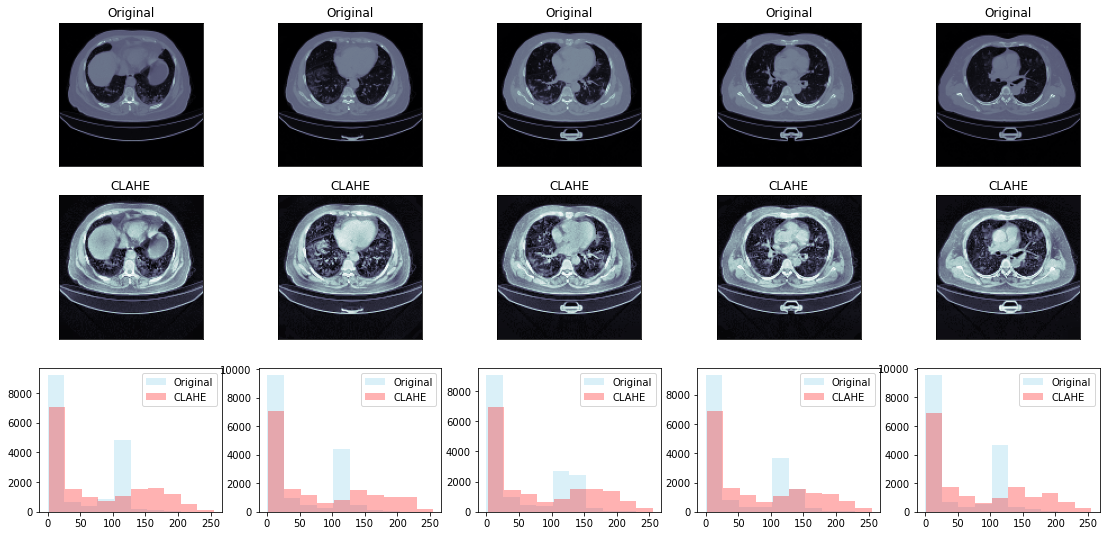

In [ ]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
# print(cts)
a = cts.get_fdata()
a = np.rot90(np.array(a))
a = a[:,:,range(100,200,20)]
# print(a)
a = np.reshape(np.rollaxis(a, 2),(a.shape[2],a.shape[0],a.shape[1], 1))

fig, axes = plt.subplots(3, 5, figsize=(19,9))

for ii in range(a.shape[0]):
    img = cv.resize(a[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA) # Resizing the images into 100 x 100
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii])) # Applying contrast
 
 

# 2. Cropping the image

The area of interest for this project is the area where lungs are located. Area other than that is of no use we will crop out the image and store only the area in which we are interested in.

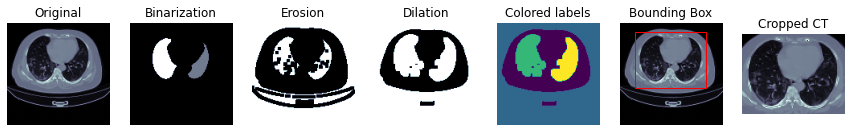

[19, 11, 89, 70]

In [ ]:
def crop_lung(img, boundaries):
  minx, miny, maxx, maxy = boundaries
  return img[miny:miny+maxy, minx:minx+maxx]

def lung_mask_crop(img, mask, dis=False):
  ht, wd = mask.shape
  _, thresh = cv.threshold(mask.astype('uint8'), 0.5, 1, 0)
  contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  img_cnt = cv.drawContours(mask, contours, -1, (0,255,0), 3)
  if len(contours) < 2 :
      raise Exception("Error")
  x0, y0, w0, h0 = cv.boundingRect(contours[0])
  x1, y1, w1, h1 = cv.boundingRect(contours[1])
  B = [min(x0,x1)-round(0.05*wd), min(y0,y1)-round(0.05*ht), max(x0+w0,x1+w1)-min(x0,x1)+round(0.1*wd), 
        max(y0+h0,y1+h1)-min(y0,y1)+round(0.1*ht)]
  B = [max(B[0],0), max(B[1],0), min(B[2], wd), min(B[3], ht)]
  cct_img = crop_lung(img, B)
  rect = patches.Rectangle((B[0],B[1]),B[2],B[3],linewidth=1,edgecolor='r',facecolor='none')

  ht, wd = img.shape
  img = (img-np.mean(img))/np.std(img)
  middle = img[int(wd/5):int(wd/5*4),int(ht/5):int(ht/5*4)] 
  mean = np.mean(middle)  
  imgmax = np.max(img)
  imgmin = np.min(img)
  img[img==imgmax]=mean
  img[img==imgmin]=mean

  # Using KMeans to find clusters or groups of lungs
  kmeans = KMeans(n_clusters=2).fit(np.reshape(middle, [np.prod(middle.shape),1]))
  centers = sorted(kmeans.cluster_centers_.flatten())
  binary = np.mean(centers)
  binarized = np.where(img<binary,1.0,0.0)

  # Using morphological technique erosion and dilation to perfecty seperate out the individual labels
  eroded = morph.erosion(binarized,np.ones([4,4]))
  dilation = morph.dilation(eroded,np.ones([6,6]))

  labels = measure.label(dilation)
  label_vals = np.unique(labels)
  # print(label_vals)   # Got 4 labels lung1, lung2, CT backgroud, true background 
  regions = measure.regionprops(labels)
  good_labels = []
  try :
    Lung1 = regions[1].bbox
    Lung2 = regions[2].bbox
    bounds = [min(Lung1[0], Lung2[0]), min(Lung1[1], Lung2[1]),
              max(Lung1[2], Lung2[2]), max(Lung1[3], Lung2[3])]
    # print(bounds)
  except :
    bounds = [ht, wd, 0, 0]
  
  if dis:
    fig, ax = plt.subplots(1, 7, figsize=[15, 3])
    ax[0].set_title("Original")
    ax[0].imshow(img, cmap='bone')
    ax[0].axis('off')
    ax[1].set_title("Binarization")
    ax[1].imshow(img_cnt, cmap='bone')
    ax[1].axis('off')
    ax[2].set_title("Erosion")
    ax[2].imshow(eroded, cmap='bone')
    ax[2].axis('off')
    ax[3].set_title("Dilation")
    ax[3].imshow(dilation, cmap='bone')
    ax[3].axis('off')
    ax[4].set_title("Colored labels")
    ax[4].imshow(labels)
    ax[4].axis('off')
    ax[5].set_title("Bounding Box")
    ax[5].imshow(img, cmap='bone')
    ax[5].add_patch(rect)
    ax[5].axis('off')
    ax[6].set_title("Cropped CT")
    ax[6].imshow(crop_lung(img, B), cmap='bone')
    ax[6].axis('off')
    plt.show()

  return B

lung_ = nib.load(metadata.loc[0, 'lung_mask'])
a_lung_ = lung_.get_fdata()
a_lung_ = np.rot90(np.array(a_lung_))
a_lung_ = a_lung_[:,:,range(100,200,10)]
a_lung_ = np.reshape(np.rollaxis(a_lung_, 2),(a_lung_.shape[2],a_lung_.shape[0],a_lung_.shape[1], 1))

img = cv.resize(a[3], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
lmask = cv.resize(a_lung_[3], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
lung_mask_crop(img, lmask, dis=True)



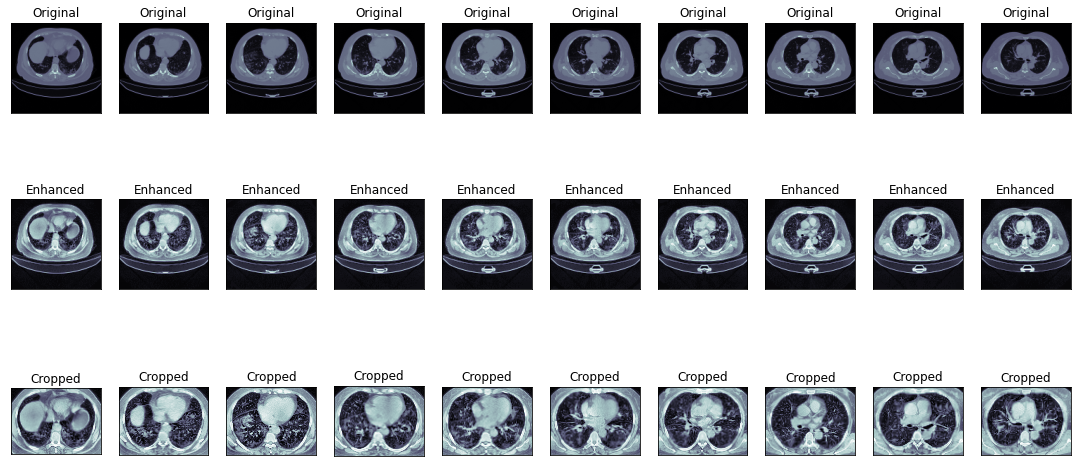

In [ ]:
a = cts.get_fdata()
a = np.rot90(np.array(a))
a = a[:,:,range(100,200,10)]
a = np.reshape(np.rollaxis(a, 2),(a.shape[2],a.shape[0],a.shape[1], 1))

fig, axes = plt.subplots(3, 10, figsize=(19,9))
fig = plt.subplots_adjust(hspace=0.3)

for ii in range(a.shape[0]):
    img = cv.resize(a[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    lmask = cv.resize(a_lung_[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original')
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe, [])
    axes[1,ii].imshow(clahe_img, cmap='bone')
    axes[1,ii].set_title('Enhanced')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

    bounds = lung_mask_crop(img, lmask)
    cropped_img = crop_lung(clahe_img, bounds)
    axes[2,ii].imshow(cropped_img, cmap='bone')
    axes[2,ii].set_title('Cropped')
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

    

Let us apply the above techniques on infection and lung mask

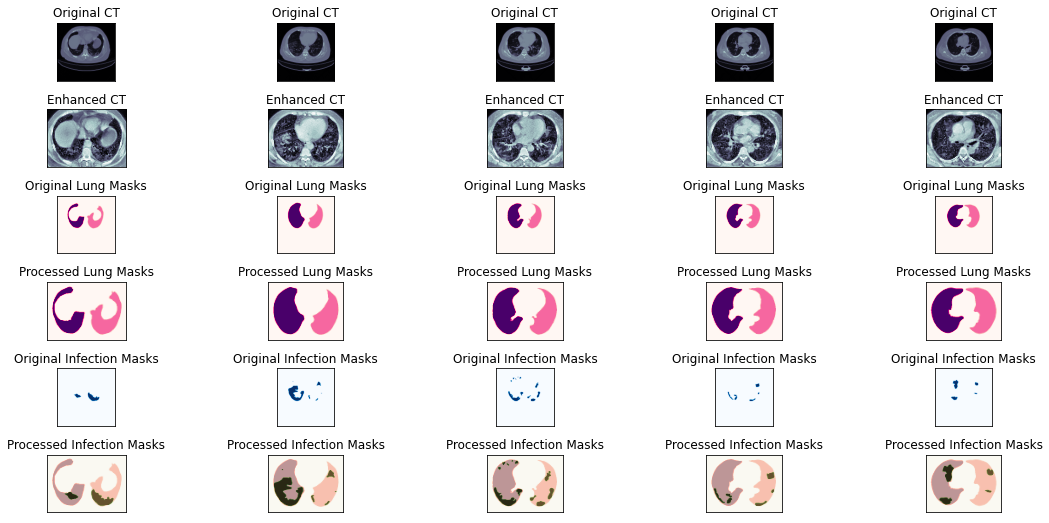

In [ ]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
a_cts = cts.get_fdata()
a_cts = np.rot90(np.array(a_cts))
a_cts = a_cts[:,:,range(100,200,20)]
a_cts = np.reshape(np.rollaxis(a_cts, 2),(a_cts.shape[2],a_cts.shape[0],a_cts.shape[1], 1))

inf = nib.load(metadata.loc[0, 'infection_mask'])
a_inf = inf.get_fdata()
a_inf = np.rot90(np.array(a_inf))
a_inf = a_inf[:,:,range(100,200,20)]
a_inf = np.reshape(np.rollaxis(a_inf, 2),(a_inf.shape[2],a_inf.shape[0],a_inf.shape[1], 1))

lung = nib.load(metadata.loc[0, 'lung_mask'])
a_lung = lung.get_fdata()
a_lung = np.rot90(np.array(a_lung))
a_lung = a_lung[:,:,range(100,200,20)]
a_lung = np.reshape(np.rollaxis(a_lung, 2),(a_lung.shape[2],a_lung.shape[0],a_lung.shape[1], 1))

fig, axes = plt.subplots(6, 5, figsize=(19,9))
fig = plt.subplots_adjust(hspace=0.5)

for i in range (a_cts.shape[0]):
  img_cts = cv.resize(a_cts[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
  img_lung = cv.resize(a_lung[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
  img_lung_o = cv.resize(a_lung[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
  img_inf = cv.resize(a_inf[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

  xmax, xmin = img_cts.max(), img_cts.min()
  img_cts = (img_cts - xmin)/(xmax - xmin)

  bounds = lung_mask_crop(img_cts, img_lung)

  axes[0,i].imshow(img_cts, cmap='bone')
  axes[0,i].set_title('Original CT')
  axes[0,i].set_xticks([]); axes[0,i].set_yticks([])
  
  img_cts = clahe_enhancer(img_cts, clahe, [])
  img_cts = crop_lung(img_cts, bounds)
  axes[1,i].imshow(img_cts, cmap='bone')
  axes[1,i].set_title('Enhanced CT')
  axes[1,i].set_xticks([]); axes[1,i].set_yticks([])

  axes[2,i].imshow(img_lung_o, cmap='RdPu')
  axes[2,i].set_title('Original Lung Masks')
  axes[2,i].set_xticks([]); axes[2,i].set_yticks([])

  img_lung_o = crop_lung(img_lung_o, bounds)
  axes[3,i].imshow(img_lung_o, cmap='RdPu')
  axes[3,i].set_title('Processed Lung Masks')
  axes[3,i].set_xticks([]); axes[3,i].set_yticks([])
  
  axes[4,i].imshow(img_inf, cmap='Blues')
  axes[4,i].set_title('Original Infection Masks')
  axes[4,i].set_xticks([]); axes[4,i].set_yticks([])

  img_inf = crop_lung(img_inf, bounds)
  axes[5,i].imshow(img_lung_o, cmap='Reds')
  axes[5,i].imshow(img_inf, alpha=0.6, cmap='Greens')
  axes[5,i].set_title('Processed Infection Masks')
  axes[5,i].set_xticks([]); axes[5,i].set_yticks([])



# 4. Loading all the data

Let us now load all the data and convert them into tensors

In [ ]:
all_cts = []
all_inf = []
all_lungs = []
bad_id = []

for i in tqdm.tqdm(range(20)) :
  cts = nib.load(metadata.loc[i, 'ct_scan'])
  inf = nib.load(metadata.loc[i, 'infection_mask'])
  lung = nib.load(metadata.loc[i, 'lung_mask'])

  a_cts = cts.get_fdata()
  a_inf = inf.get_fdata()
  a_lung = lung.get_fdata()

  slice_range = range(round(a_cts.shape[2]*0.2), round(a_cts.shape[2]*0.8))

  a_cts = np.rot90(np.array(a_cts))
  a_cts = a_cts[:,:,slice_range]
  a_cts = np.reshape(np.rollaxis(a_cts, 2),(a_cts.shape[2],a_cts.shape[0],a_cts.shape[1], 1))
  
  a_inf = np.rot90(np.array(a_inf))
  a_inf = a_inf[:,:,slice_range]
  a_inf = np.reshape(np.rollaxis(a_inf, 2),(a_inf.shape[2],a_inf.shape[0],a_inf.shape[1], 1))

  a_lung = np.rot90(np.array(a_lung))
  a_lung = a_lung[:,:,slice_range]
  a_lung = np.reshape(np.rollaxis(a_lung, 2),(a_lung.shape[2],a_lung.shape[0],a_lung.shape[1], 1))

  print(a_cts.shape)
  print(a_lung.shape)
  print(a_inf.shape)

  for j in range(a_cts.shape[0]):
    try:
      img_cts = cv.resize(a_cts[j], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
      img_lung = cv.resize(a_lung[j], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
      img_lung_o = cv.resize(a_lung[j], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
      img_inf = cv.resize(a_inf[j], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

      xmax, xmin = img_cts.max(), img_cts.min()
      img_cts = (img_cts - xmin)/(xmax - xmin)

      bounds = lung_mask_crop(img_cts, img_lung)

      img_cts = clahe_enhancer(img_cts, clahe, [])
      img_cts = crop_lung(img_cts, bounds)
      all_cts.append(img_cts)

      img_lung_o = crop_lung(img_lung_o, bounds)
      all_lungs.append(img_lung_o)

      img_inf = crop_lung(img_inf, bounds)
      all_inf.append(img_inf)
    except:
      bad_id.append(j)
 

In [ ]:
print(len(all_cts))
print(len(all_lungs))
print(len(all_inf))

2063
2063
2063


Reshape the nparray to 128 x 128 x 1

In [ ]:
del_lst = []
for i in tqdm.tqdm(range(len(all_cts))) :
  try :
    all_cts[i] = cv.resize(all_cts[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    all_cts[i] = np.reshape(all_cts[i], (img_size, img_size, 1))
    all_lungs[i] = cv.resize(all_lungs[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    all_lungs[i] = np.reshape(all_lungs[i], (img_size, img_size, 1))
    all_inf[i] = cv.resize(all_inf[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    all_inf[i] = np.reshape(all_inf[i], (img_size, img_size, 1))
  except :
    del_lst.append(i)      

for idx in del_lst[::-1] :
  del all_cts[idx]
  del all_lungs[idx]
  del all_inf[idx]
  


In [ ]:
print(len(all_cts))
print(len(all_lungs))
print(len(all_inf))

2063
2063
2063


# 5. Final Visualization

Text(0.5, 1.0, 'Processed Infection Mask')

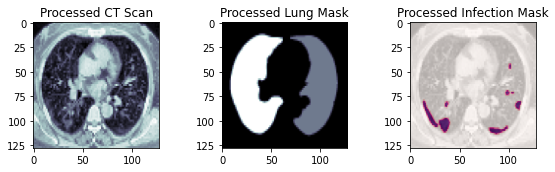

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))
fig = plt.subplots_adjust(wspace=0.5)
axes[0].imshow(all_cts[100][:, :, 0], cmap='bone')
axes[0].set_title("Processed CT Scan")

axes[1].imshow(all_lungs[100][:, :, 0], cmap='bone')
axes[1].set_title("Processed Lung Mask")

axes[2].imshow(all_cts[100][:, :, 0], cmap='gray')
axes[2].imshow(all_inf[100][:, :, 0], alpha=0.7, cmap='RdPu')
axes[2].set_title("Processed Infection Mask")


# 6. Deleting blank masks
Deleting the blank infection mask is important so that our model can easily predict the desired infection mask required.

Here we will delete all the black infection masks along with their corresponding ct scans and lung masks. To approach this we will use np.unique to identify the unique elemtns and if its size is 1 it means the mask is blank and then store the result in an index_arr list.

Then sort the index_arr list in descending order and using del delete the index on ct scans, lung masks as well as blank infection masks.

Number of CTS with no infection  499
Number of CT slices available after deletion of non-infection masks  1564


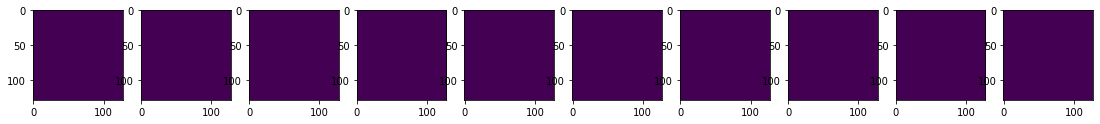

In [ ]:
total_slides = len(all_cts)
index_arr = []
inf_check = np.ones((1, len(all_inf)))
for i in range(len(all_inf)):
  if np.unique(all_inf[i]).size == 1:
    inf_check[0, i] = 0
    index_arr.append(i)

print("Number of CTS with no infection ", len(index_arr))

# Testing the black masks
fig, axes = plt.subplots(1, 10, figsize=(19,9))
tmp = 0
for i in index_arr:
  img_inf = cv.resize(all_inf[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
  axes[tmp].imshow(img_inf)
  tmp += 1
  if tmp==10:
    break

for i in index_arr[::-1]:
  del all_cts[i]
  del all_inf[i]
  del all_lungs[i]

print("Number of CT slices available after deletion of non-infection masks ", len(all_cts))


In [ ]:
all_cts = np.array(all_cts)
all_lungs = np.array(all_lungs)
all_inf = np.array(all_inf)

print(all_cts.shape)
print(all_lungs.shape)
print(all_inf.shape)


(1564, 128, 128, 1)
(1564, 128, 128, 1)
(1564, 128, 128, 1)


# 7. Viewing the final fully processed images


In [ ]:
def plot_cts_infects(ct, infect, axes) :

    axes[0].imshow(ct[:,:,0], cmap='bone')
    axes[0].set_title('CT image')

    axes[1].imshow(ct[:,:,0], cmap='bone')
    axes[1].imshow(infect[:,:,0], alpha=0.5, cmap='nipy_spectral')
    axes[1].set_title('Infection')

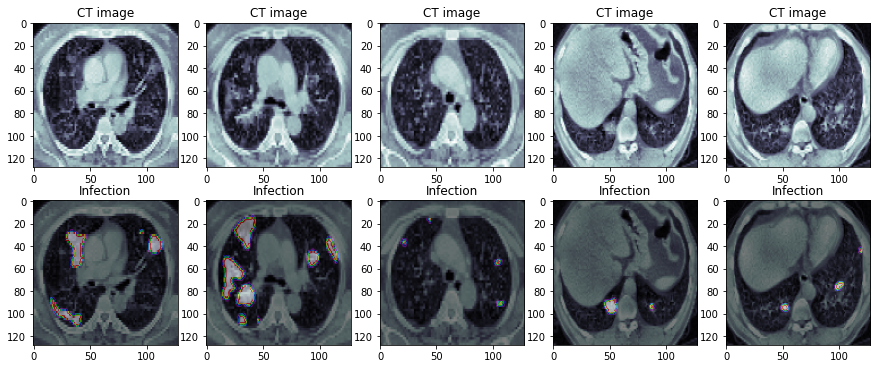

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15,6))

for ii, idx in enumerate(range(100, 200, 20)) :
    plot_cts_infects(all_cts[idx], all_inf[idx], list(axes[:,ii]))

# 8. Saving Data
Save these processed images so that this procedure can be avoided in future.

In [ ]:
with open('Processed_Data.cp', 'wb') as myfile:
    pickle.dump({'cts': all_cts, 'lungs': all_lungs, 'infects': all_inf}, myfile)